In [1]:
import stable_baselines3
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import gym
from simulation_view import SimulationView
import numpy as np


def get_simulation_view():
    return SimulationView([8000, 2000], [0, 0])


class Environment(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(Environment, self).__init__()
        self.reward_range = (0, 1)
        self.action_space = gym.spaces.Box(np.array([0]), np.array([1]), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=1e5, shape=(2,))
        self.simulation_view = get_simulation_view()
        self.simulation_step = 0

    def step(self, action):
        old_obs = list(self.simulation_view.simulation.entityCount)
        self.simulation_view.step([action[0] * 1e5, 0])
        obs = list(self.simulation_view.simulation.entityCount)
        # reward = 1e5 - np.abs(self.simulation_view.simulation.entityCount[0] - self.simulation_view.simulation.entityCount[1])
        # reward = self.simulation_step
        # reward = 1
        reward = 1 - min(abs(1 - np.average(np.array(obs) / np.array(old_obs))), 1)
        done = np.any(np.array(self.simulation_view.simulation.entityCount) < 100)
        if self.simulation_step > 1000:
            done = True
        self.simulation_step += 1

        return obs, reward, done, {}

    def reset(self):
        self.simulation_view = get_simulation_view()
        self.simulation_step = 0
        return list(self.simulation_view.simulation.entityCount)

    def render(self, mode='human', close=False):
        print(list(self.simulation_view.simulation.entityCount))

In [14]:
def get_random_model():
    env = Environment()
    return PPO('MlpPolicy', env, verbose=0)


def learn_model():
    model = get_random_model()
    model.learn(total_timesteps=2000000)
    return model


def simulate_model(model, verbose=True):
    env = Environment()
    obs = env.reset()
    i = 0
    done = False
    while not done:
        i += 1
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if verbose:
            print("[%d] obs = [%d, %d], food = %f" % (i, obs[0], obs[1], action[0]))
    return i
    

def test_model(model):
    scores = []
    for _ in range(1000):
        score = simulate_model(model, verbose=False)
        scores.append(score)
    plt.hist(scores, bins=np.arange(0, max(scores) + 20, 20))
    plt.show()
    print("Average score: %f" % np.average(scores))

In [4]:
model = learn_model()

/home/piotr/Projects/anfis_game_of_life/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


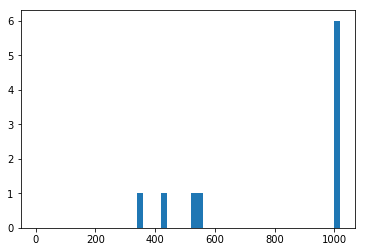

Average score: 787.200000


In [12]:
test_model(model)

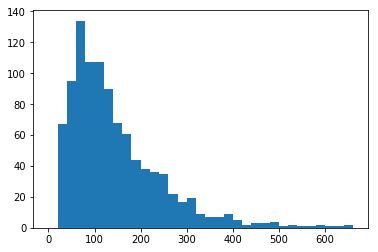

Average score: 145.217000


In [6]:
test_model(get_random_model())

In [7]:
model.save("model.zip")

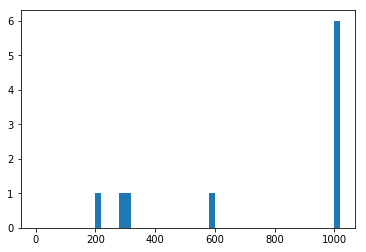

Average score: 742.700000


In [10]:
loaded_model = PPO.load("model.zip")
test_model(model)